# First Order State-Variable-Filter - Cython extern C code

2020-06-16 ug

Create a fixedpoint state variable filter in C Code and compile it a as Cython module

Algorithmus: Zustandsvariablenfilter               
                                                    
Initialisierung:                                   
f_x(0) = 0                                         
df_x(0) = 0                                        
                                                    
Update-Schritt:                                    
      tmp = (u(k) - f_x(k))/T;                     
 f_x(k+1) = f_x(k) + (tmp  + df_x(k)) * dT/2;      
df_x(k+1) = tmp;                                  
                                                    
  T    : Filterzeitkonstante                      
  dT   : Abtastzeit                               
  f_x  : Ausgang: Filterung                       
  df_x : Ausgang: Ableitung                       
  u    : Eingang                                  
  k    : Abtastschritt     

Reference SVF:
    ???

Reference Cython:

https://github.com/cython/cython/wiki/tutorials-NumpyPointerToC

http://docs.cython.org/en/latest/src/userguide/memoryviews.html#pass-data-from-a-c-function-via-pointer

**Step1:** load the Cython extension `%load_ext cython' from within the Jupyter notebook

In [1]:
%load_ext cython

## SVF - State Variable Filter - First Order

Nebenrechnung: Quantisierung von Filterzeitkonstant $T$ und Abtastzeit $dT$

In [2]:
# Filterzeitkonstante T
T_real = 0.1    # 100ms
T_quant = 256   # 1/256 secs
T_fixPoint = int(T_real*T_quant+.5)
T_fixPoint


26

In [3]:
# Abtastzeit dT
dT_real = 0.01  # 10ms
dT_quant = 2048 # 1/2048 secs
dT_fixPoint = int(dT_real*dT_quant+0.5)
dT_fixPoint

20

## Create Files

Files to be created:

C Code files - C_SVF_1o_int.c/.h    (int for integer implementation)
    
C Code files - C_SVF_1o_wrapper.c/.h

Cython File  - SVF_int.pyx

Python file  - setup.py

### C Code files   C_SVF_1o_int.h

In [4]:
%%writefile C_SVF_1o_int.h
#ifndef C_SVF_1o_INT_H
#define C_SVF_1o_INT_H

typedef signed long           sint32;        /* -2147483648 .. +2147483647     */

// interal SVF state
typedef struct
{
    sint32 f_x;   // Ausgang: Filterung 
    sint32 df_x;  // Ausgang: Ableitung 
}tSVF_state;     

void SVF_int_init(tSVF_state *SVF_state,sint32 f_x_0);
void SVF_int_calc(tSVF_state *SVF_state, sint32 u, unsigned char dT, unsigned char T);
sint32 Get_f_x(tSVF_state *SVF_state);
sint32 Get_df_x(tSVF_state *SVF_state);

#endif

Writing C_SVF_1o_int.h


### C Code files   C_SVF_1o_int.c

In [5]:
%%writefile C_SVF_1o_int.c
#include "C_SVF_1o_int.h"

// -------------------------------------------------- 
//                                                    
// Algorithmus: Zustandsvariablenfilter               
//                                                    
// Initialisierung:                                   
// f_x(0) = 0                                         
// df_x(0) = 0                                        
//                                                    
// Update-Schritt:                                    
//       tmp = (u(k) - f_x(k))/T;                     
//  f_x(k+1) = f_x(k) + (tmp  + df_x(k)) * dT/2;      
//  df_x(k+1) = tmp;                                  
//                                                    
//  T    : Filterzeitkonstante                      
//  dT   : Abtastzeit                               
//  f_x  : Ausgang: Filterung                       
//  df_x : Ausgang: Ableitung                       
//  u    : Eingang                                  
//  k    : Abtastschritt                            

#define FILTER_TIEFE 8
#define UPPER_LIMIT  1073741823  /* 2^30-1 */
#define LOWER_LIMIT -1073741824  /* -2^30  */

#define limit(x1,x2,x3) (x2=((x2)<(x1)?(x1):((x2)>(x3)?(x3):(x2))))


// ----------------------------------------
// SVF Fix point implementation

void SVF_int_init(tSVF_state *SVF_state,sint32 f_x_0)
{
    sint32 tmp32bit;
    tmp32bit    = f_x_0;
    tmp32bit  <<= FILTER_TIEFE;
    (*SVF_state).f_x = tmp32bit;   // Ausgang: Filterung  
    (*SVF_state).df_x = 0;         // Ausgang: Ableitung 

}

void SVF_int_calc(tSVF_state *SVF_state, sint32 u, unsigned char dT, unsigned char T)
{
    // tSVF_state *SVF_state
    // sint32 u            - input
    // unsigned char  dT   - Abtastzeit:           10ms  (1/2048)    
    // unsigned char  T    - Filterzeitkonstante: 100ms  (1/256)
    // sint32 *f_x_return  - filtered input
    // sint32 *df_x_return - filtered derivated input

    // lokale Kopien
    sint32 f_x;   // Ausgang: Filterung 
    sint32 df_x;  // Ausgang: Ableitung 

    // struct SVF_state -> lokale Kopien
    f_x = (*SVF_state).f_x;
    df_x = (*SVF_state).df_x;
    
    
    // Register fuer temporaere Verwendung
    sint32 tmp32bit;
    sint32 tmp32bit2;

    //unsigned char   T = 26;    // Filterzeitkonstante: 100ms  (1/256)  
    //unsigned char  dT = 20;    // Abtastzeit:           10ms  (1/2048) 

    
    tmp32bit = u;    // input
    
    tmp32bit  <<= FILTER_TIEFE;
    tmp32bit   -= f_x;

    tmp32bit  <<= 8;     // Quantisierung T
    tmp32bit   /= (sint32) T;
    tmp32bit = limit(LOWER_LIMIT,tmp32bit,UPPER_LIMIT);
  
    tmp32bit2   = tmp32bit;
    tmp32bit2  += df_x;
    tmp32bit2  *= (sint32) dT;
    tmp32bit2 >>=11+1;  // Quantisierung dT und Faktor 1/2
    tmp32bit2 = limit(LOWER_LIMIT,tmp32bit2,UPPER_LIMIT);

    f_x         = f_x + tmp32bit2;
    df_x        = tmp32bit;
  
    
    // lokale Kopien -> struct SVF_state
    (*SVF_state).f_x = f_x;
    (*SVF_state).df_x = df_x; 
        
}

// return Methoden
sint32 Get_f_x(tSVF_state *SVF_state)
{
    // Register fuer temporaere Verwendung
    sint32 tmp32bit;
        
    // f_x ausgeben 
    tmp32bit   =  (*SVF_state).f_x;
    tmp32bit >>= FILTER_TIEFE;
    tmp32bit   = limit(-30000,tmp32bit,30000);
    return tmp32bit;
}
sint32 Get_df_x(tSVF_state *SVF_state)
{
    // Register fuer temporaere Verwendung
    sint32 tmp32bit;
    
    // df_x ausgeben 
    tmp32bit   = (*SVF_state).df_x;
    tmp32bit >>= FILTER_TIEFE;
    tmp32bit   = limit(-30000,tmp32bit,30000);
    return tmp32bit;
}

Writing C_SVF_1o_int.c


### C Code files C_SVF_1o_wrapper.h

In [6]:
%%writefile C_SVF_1o_wrapper.h
#ifndef C_SVF_1o_wrapper_H
#define C_SVF_1o_wrapper_H


void run_SVF_in_C(unsigned int N, 
                  double dT, 
                  double T, 
                  double f_x_0, 
                  double inp[], 
                  double f_x_out[], 
                  double df_x_out[]);

#endif

Writing C_SVF_1o_wrapper.h


### C Code files C_SVF_1o_wrapper.c

In [7]:
%%writefile C_SVF_1o_wrapper.c

#include "C_SVF_1o_int.h"

// ------------------------------------
void run_SVF_in_C(unsigned int N, double dT, double T, double f_x_0, double inp[], double f_x_out[], double df_x_out[])
{
    tSVF_state SVF_state;
    sint32 tmp32bit;
    unsigned int i;
    sint32 f_x_return, df_x_return;
    sint32 u;
    unsigned char  dT_fixPoint;
    unsigned char  T_fixPoint;
    
    // Skalierung dT und T
    dT_fixPoint = (unsigned char)(dT*2040.0+0.5);    // Abtastzeit:  10ms  (1/2048)    
    T_fixPoint  = (unsigned char)(T*256.0+0.5);      // Filterzeitkonstante: 100ms  (1/256)

    
    // initialize
    tmp32bit = (double)f_x_0;
    SVF_int_init(&SVF_state,tmp32bit);
    
    // loop
    for (i = 0; i < N; i++) {
        u = (sint32) inp[i];
        
        SVF_int_calc(&SVF_state, u, dT_fixPoint, T_fixPoint);
        
        f_x_return = Get_f_x(&SVF_state);
        df_x_return = Get_df_x(&SVF_state);
        
        f_x_out[i]  = (double) f_x_return;
        df_x_out[i] = (double) df_x_return;

    }
}

Writing C_SVF_1o_wrapper.c


### Cython File -  SVF_int.pyx

define a Python function 'SVF_1o' that call the C code wrapper 'run_SVF_in_C'

In [8]:
%%writefile SVF_int.pyx

cdef extern from "C_SVF_1o_wrapper.h":
    void run_SVF_in_C(unsigned int N, double dT, double T, double f_x_0, double inp[], double f_x_out[], double df_x_out[])


import numpy as np

def SVF_1o(inp, f_x_out, df_x_out, dT,T, f_x_0): # 'arr' is a one-dimensional numpy array

    if not inp.flags['C_CONTIGUOUS']:
        inp = np.ascontiguousarray(inp)           # Makes a contiguous copy of the numpy array.
    if not f_x_out.flags['C_CONTIGUOUS']:
        f_x_out = np.ascontiguousarray(f_x_out)   # Makes a contiguous copy of the numpy array.
    if not df_x_out.flags['C_CONTIGUOUS']:
        df_x_out = np.ascontiguousarray(df_x_out) # Makes a contiguous copy of the numpy array.

        
    cdef double[::1] inp_memview = inp
    cdef double[::1] f_x_out_memview = f_x_out
    cdef double[::1] df_x_out_memview = df_x_out
    cdef double dT_tmp = dT
    cdef double T_tmp = T
    cdef double f_x_0_tmp = f_x_0
       
    run_SVF_in_C(f_x_out_memview.shape[0], dT_tmp, T_tmp, f_x_0_tmp, &inp_memview[0], &f_x_out_memview[0],&df_x_out_memview[0])
   

    return f_x_out, df_x_out

Writing SVF_int.pyx


### Python file - setup.py
setup shall create Cython module 'Cython_SVF_1o'

In [9]:
%%writefile setup.py
from distutils.core import setup, Extension
from Cython.Build import cythonize

ext = Extension('Cython_SVF_1o', 
                language="c", 
                sources = ['SVF_int.pyx', 'C_SVF_1o_wrapper.c', 'C_SVF_1o_int.c'])

setup(name="Cython_SVF_1o", 
      ext_modules = cythonize([ext]))

Writing setup.py


## Compile  -  call setup.py

`--inplace`  Cython module will be create in the same directory where setup.py is.

In [10]:
!python setup.py build_ext --inplace

Compiling SVF_int.pyx because it changed.
[1/1] Cythonizing SVF_int.pyx
running build_ext
building 'Cython_SVF_1o' extension
creating build
creating build\temp.win-amd64-3.7
creating build\temp.win-amd64-3.7\Release
C:\Program Files (x86)\Microsoft Visual Studio\2019\Community\VC\Tools\MSVC\14.24.28314\bin\HostX86\x64\cl.exe /c /nologo /Ox /W3 /GL /DNDEBUG /MD -IC:\Users\guecker\Anaconda3\envs\SignalProc\include -IC:\Users\guecker\Anaconda3\envs\SignalProc\include "-IC:\Program Files (x86)\Microsoft Visual Studio\2019\Community\VC\Tools\MSVC\14.24.28314\ATLMFC\include" "-IC:\Program Files (x86)\Microsoft Visual Studio\2019\Community\VC\Tools\MSVC\14.24.28314\include" "-IC:\Program Files (x86)\Windows Kits\NETFXSDK\4.8\include\um" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.18362.0\ucrt" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.18362.0\shared" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.18362.0\um" "-IC:\Program Files (x86)\Windows Kits\10\include\10.

C:\Users\guecker\Anaconda3\envs\SignalProc\lib\site-packages\Cython\Compiler\Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\guecker\Documents\GitHub\Python_Expedition\_5_Topics\DSP\IIR_Filter\SVF\SVF_1_order\SVF_int.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


## Run Filter

In [11]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import created module 'Cython_SVF_1o'

In [12]:
import Cython_SVF_1o

call function 'SVF_1o' from module 'Cython_SVF_1o'

In [13]:
# Step impulse response
N = 200
dt = 0.01
T = 0.3
f_x_0 = 0
N_leader = 9
t = (np.arange(N)-N_leader+1)*dt
inp = np.zeros_like(t, dtype=np.double)
f_x_out = np.zeros_like(t, dtype=np.double)
df_x_out = np.zeros_like(t, dtype=np.double)


inp[N_leader:-100] = 1000

Cython_SVF_1o.SVF_1o(inp, f_x_out, df_x_out, dt,T, f_x_0)

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  16.,  48.,
         79., 110., 139., 168., 195., 222., 247., 272., 296., 319., 342.,
        364., 385., 405., 424., 443., 462., 480., 497., 513., 529., 545.,
        560., 574., 588., 602., 615., 628., 640., 652., 663., 675., 685.,
        696., 706., 715., 725., 734., 743., 751., 759., 767., 775., 782.,
        789., 796., 803., 810., 816., 822., 828., 833., 839., 844., 849.,
        854., 859., 864., 868., 873., 877., 881., 885., 889., 892., 896.,
        899., 902., 906., 909., 912., 915., 917., 920., 923., 925., 928.,
        930., 932., 935., 937., 939., 941., 943., 945., 946., 948., 950.,
        952., 937., 906., 876., 847., 819., 792., 766., 741., 716., 693.,
        670., 648., 626., 605., 585., 566., 547., 529., 512., 495., 479.,
        463., 447., 433., 418., 404., 391., 378., 366., 354., 342., 331.,
        320., 309., 299., 289., 279., 270., 261., 253., 244., 236., 228.,
        221., 213., 206., 200., 193., 

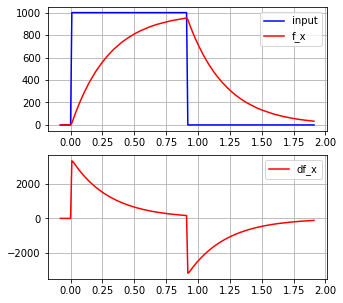

In [14]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(5, 5))
ax1.plot(t, inp, 'b',label ='input')
ax1.plot(t, f_x_out, 'r',label = 'f_x')
ax1.legend()
ax1.grid()

ax2.plot(t, df_x_out, 'r',label = 'df_x')
ax2.legend()
ax2.grid()

### Sinus

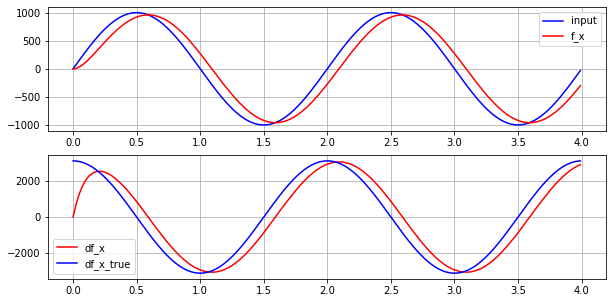

In [15]:
N = 400
dt = 0.01
T = 0.1
f_x_0 = 0
f0 = 0.5    # Sinus with 1 Hz
t = np.arange(N)*dt
inp = 1000*np.sin(2*np.pi*f0*t)
f_x_out = np.zeros_like(t, dtype=np.double)
df_x_out = np.zeros_like(t, dtype=np.double)

# calculated true dervation
df_x_true = 1000*2*np.pi*f0*np.cos(2*np.pi*f0*t)

Cython_SVF_1o.SVF_1o(inp, f_x_out, df_x_out, dt,T, f_x_0);

fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(10, 5))
ax1.plot(t, inp, 'b',label ='input')
ax1.plot(t, f_x_out, 'r',label = 'f_x')
ax1.legend()
ax1.grid()

ax2.plot(t, df_x_out, 'r',label = 'df_x')
ax2.plot(t, df_x_true, 'b',label = 'df_x_true')


ax2.legend()
ax2.grid()

# Clean up

In [16]:
import os
import shutil

def deleteFile(FileName):
    print(f'deleting file {FileName}', end ='')
    try:
        os.remove(FileName)
        print(' done')
    except OSError:
        print(' skipped')
def deleteFolder(FolderPathName):
    # https://stackoverflow.com/questions/185936/how-to-delete-the-contents-of-a-folder
    print('deleting folder %s'%FolderPathName,end='')
    try:
        shutil.rmtree(FolderPathName)   # , ignore_errors=True
        print(' done')
    except OSError:
        print(' skipped')

In [18]:
fileList = ['SVF_int.pyx',
            'C_SVF_1o_int.c',
            'C_SVF_1o_int.h',
            'C_SVF_1o_wrapper.c',
            'C_SVF_1o_wrapper.h',s
            'setup.py',
            'SVF_int.c']
for file in fileList:
    deleteFile(file)
deleteFolder(r'.\build')

deleting file SVF_int.pyx skipped
deleting file C_SVF_1o_int.c skipped
deleting file C_SVF_1o_int.h skipped
deleting file C_SVF_1o_wrapper.c skipped
deleting file C_SVF_1o_wrapper.h skipped
deleting file Cython_SVF_1o.cp37-win_amd64.pyd skipped
deleting file setup.py done
deleting file SVF_int.c skipped
deleting folder .\build skipped


In [20]:
#'Cython_SVF_1o.cp37-win_amd64.pyd' cannot be delete because it is opened
#os.remove('Cython_SVF_1o.cp37-win_amd64.pyd')